In [ ]:
! pip install -q kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir data
! cd data
! kaggle datasets download -d aayush9753/image-colorization-dataset

mkdir: cannot create directory ‘data’: File exists
 99% 470M/473M [00:03<00:00, 149MB/s]
100% 473M/473M [00:03<00:00, 154MB/s]


In [ ]:
! unzip /content/image-colorization-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_color/image0000.jpg  
  inflating: data/train_color/image0001.jpg  
  inflating: data/train_color/image0002.jpg  
  inflating: data/train_color/image0003.jpg  
  inflating: data/train_color/image0004.jpg  
  inflating: data/train_color/image0005.jpg  
  inflating: data/train_color/image0006.jpg  
  inflating: data/train_color/image0007.jpg  
  inflating: data/train_color/image0008.jpg  
  inflating: data/train_color/image0009.jpg  
  inflating: data/train_color/image0010.jpg  
  inflating: data/train_color/image0011.jpg  
  inflating: data/train_color/image0012.jpg  
  inflating: data/train_color/image0013.jpg  
  inflating: data/train_color/image0014.jpg  
  inflating: data/train_color/image0015.jpg  
  inflating: data/train_color/image0016.jpg  
  inflating: data/train_color/image0017.jpg  
  inflating: data/train_color/image0018.jpg  
  inflating: data/train_color/image0019.jpg  
  inflating: data/train_color

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave, imread, imshow
from skimage.transform import resize

import random

In [ ]:
IMG_SIZE = 224
N_EPOCHS = 30
BATCH_SIZE = 32
latent_dim = 256

In [ ]:
! rm -r data/train_black
! rm -r data/test_color
! rm -r data/test_black

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_directory('data/',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              batch_size = BATCH_SIZE)

valid_datagen = ImageDataGenerator(rescale = 1./255)

valid_set = valid_datagen.flow_from_directory('data/',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              batch_size = BATCH_SIZE)

def gen_ab_images(train_set):
    for batch in train_set:
        lab_batch = rgb2lab(batch[0])
        X_batch = lab_batch[:,:,:,0] / 100
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

Found 5000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Flatten())
model.add(Dense(latent_dim))
model.add(Dense(14*14*256))
model.add(Reshape((14, 14, 256)))
model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2DTranspose(2, (3, 3), activation='tanh', padding='same', strides=2))       
model.compile(optimizer='rmsprop', loss='mse')

In [ ]:
tensorboard = TensorBoard(log_dir="output/first_run")
model.fit(x=gen_ab_images(train_set), 
          callbacks=[tensorboard], 
          epochs=N_EPOCHS, 
          validation_data=gen_ab_images(valid_set), 
          steps_per_epoch=len(train_set),
          validation_steps=len(valid_set))

Epoch 1/30
157/157 [==============================] - 175s 1s/step - loss: 0.0147 - val_loss: 0.0130
Epoch 2/30
157/157 [==============================] - 161s 1s/step - loss: 0.0130 - val_loss: 0.0131
Epoch 3/30
157/157 [==============================] - 150s 962ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 4/30
157/157 [==============================] - 151s 968ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 5/30
157/157 [==============================] - 161s 1s/step - loss: 0.0126 - val_loss: 0.0138
Epoch 6/30
157/157 [==============================] - 159s 1s/step - loss: 0.0124 - val_loss: 0.0122
Epoch 7/30
157/157 [==============================] - 153s 982ms/step - loss: 0.0124 - val_loss: 0.0135
Epoch 8/30
157/157 [==============================] - 155s 991ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 9/30
157/157 [==============================] - 156s 996ms/step - loss: 0.0119 - val_loss: 0.0136
Epoch 10/30
157/157 [==============================] - 163s 1s/step - loss: 

1/1 [==============================] - 0s 127ms/step - loss: 0.0108
0.01080641895532608


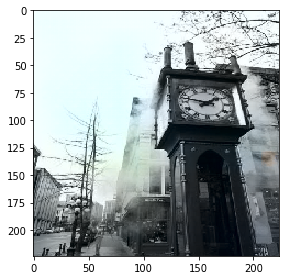

In [ ]:
batch = next(gen_ab_images(valid_set))
Xtest, Ytest = batch[0], batch[1]

print(model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE))

# Test model
output = model.predict(Xtest)
output = output * 128

# Output colorizations
i = random.randrange(len(output))
cur = np.zeros((IMG_SIZE, IMG_SIZE, 3))
cur[:,:,0] = Xtest[i][:,:,0] * 100
cur[:,:,1:] = output[i]
cur = lab2rgb(cur)
imshow(cur)

In [ ]:
model.save('model1.h5')